# Librerías

In [1]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
from scipy.ndimage import label

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout,  RepeatVector, TimeDistributed
import matplotlib.pyplot as plt

2025-05-17 08:56:26.956000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747464986.978402    8440 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747464986.986378    8440 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747464987.011417    8440 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747464987.011444    8440 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747464987.011445    8440 computation_placer.cc:177] computation placer alr

# Data

In [3]:
# 1. CARGA DE DATOS
train_df = pd.read_parquet("../data/train.parquet")
test_df = pd.read_parquet("../data/test.parquet")

train_df.head(), train_df.shape, test_df.head(), test_df.shape

(   id  channel_1  channel_10  channel_11  channel_12  channel_13  channel_14  \
 0   0    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
 1   1    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
 2   2    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
 3   3    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
 4   4    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
 
    channel_15  channel_16  channel_17  ...  telecommand_351  telecommand_352  \
 0    0.130113    0.766769    0.349474  ...              0.0              0.0   
 1    0.130113    0.766769    0.349474  ...              0.0              0.0   
 2    0.130113    0.766769    0.349474  ...              0.0              0.0   
 3    0.130113    0.766769    0.349474  ...              0.0              0.0   
 4    0.130113    0.766769    0.349474  ...              0.0              0.0   
 
    telecommand_353  tel

In [4]:
target_channels = [f'channel_{i}' for i in range(41, 47)]  # canales del 41 al 46

train_filtered_df = train_df[['id'] + target_channels]

long_format_df = train_filtered_df.melt(id_vars=['id'], var_name='unique_id', value_name='y')

long_format_df.rename(columns={'id': 'ds'}, inplace=True)

long_format_df['ds'] = pd.to_timedelta(long_format_df['ds'] - long_format_df['ds'].min(), unit='m') + pd.Timestamp("2000-01-01")

long_format_df.head(10)

,ds,unique_id,y
0,2000-01-01 00:00:00,channel_41,0.812578
1,2000-01-01 00:01:00,channel_41,0.812578
2,2000-01-01 00:02:00,channel_41,0.821213
3,2000-01-01 00:03:00,channel_41,0.819642
4,2000-01-01 00:04:00,channel_41,0.821996
5,2000-01-01 00:05:00,channel_41,0.819642
6,2000-01-01 00:06:00,channel_41,0.821996
7,2000-01-01 00:07:00,channel_41,0.820427
8,2000-01-01 00:08:00,channel_41,0.820427
9,2000-01-01 00:09:00,channel_41,0.821996


In [5]:
h = 4  # horizonte de predicción
input_size = 5  # tamaño de la ventana de entrada

# === 4. División en train/test por canal ===
train_df_final = long_format_df.groupby('unique_id').apply(lambda g: g.iloc[:-h]).reset_index(drop=True)
# test_df_final = long_format_df.groupby('unique_id').apply(lambda g: g.iloc[-h:]).reset_index(drop=True)

In [6]:
train_df_final.shape

(88369902, 3)

In [7]:
train_df_final

,ds,unique_id,y
0,2000-01-01 00:00:00,channel_41,0.812578
1,2000-01-01 00:01:00,channel_41,0.812578
2,2000-01-01 00:02:00,channel_41,0.821213
3,2000-01-01 00:03:00,channel_41,0.819642
4,2000-01-01 00:04:00,channel_41,0.821996
...,...,...,...
88369897,2028-01-01 23:52:00,channel_46,0.765296
88369898,2028-01-01 23:53:00,channel_46,0.767829
88369899,2028-01-01 23:54:00,channel_46,0.762762
88369900,2028-01-01 23:55:00,channel_46,0.761918


In [8]:
print(train_df_final)

                          ds   unique_id         y
0        2000-01-01 00:00:00  channel_41  0.812578
1        2000-01-01 00:01:00  channel_41  0.812578
2        2000-01-01 00:02:00  channel_41  0.821213
3        2000-01-01 00:03:00  channel_41  0.819642
4        2000-01-01 00:04:00  channel_41  0.821996
...                      ...         ...       ...
88369897 2028-01-01 23:52:00  channel_46  0.765296
88369898 2028-01-01 23:53:00  channel_46  0.767829
88369899 2028-01-01 23:54:00  channel_46  0.762762
88369900 2028-01-01 23:55:00  channel_46  0.761918
88369901 2028-01-01 23:56:00  channel_46  0.752628

[88369902 rows x 3 columns]


# Models

## NHITS

In [9]:
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import DistributionLoss

In [14]:
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test
Y_train_df , Y_test_df

(    unique_id         ds      y  trend  y_[lag12]
 0    Airline1 1949-01-31  112.0      0      112.0
 1    Airline1 1949-02-28  118.0      1      118.0
 2    Airline1 1949-03-31  132.0      2      132.0
 3    Airline1 1949-04-30  129.0      3      129.0
 4    Airline1 1949-05-31  121.0      4      121.0
 ..        ...        ...    ...    ...        ...
 259  Airline2 1959-08-31  859.0    271      805.0
 260  Airline2 1959-09-30  763.0    272      704.0
 261  Airline2 1959-10-31  707.0    273      659.0
 262  Airline2 1959-11-30  662.0    274      610.0
 263  Airline2 1959-12-31  705.0    275      637.0
 
 [264 rows x 5 columns],
    unique_id         ds      y  trend  y_[lag12]
 0   Airline1 1960-01-31  417.0    132      360.0
 1   Airline1 1960-02-29  391.0    133      342.0
 2   Airline1 1960-03-31  419.0    134      406.0
 3   Airline1 1960-04-30  461.0    135      396.0
 4   Airline1 1960-05-31  472.0    136      420.0
 5   Airline1 1960-06-30  535.0    137      472.0
 6   Airlin

In [19]:
len(set(Y_train_df["trend"]))

264

In [13]:
train_df_final

,ds,unique_id,y
0,2000-01-01 00:00:00,channel_41,0.812578
1,2000-01-01 00:01:00,channel_41,0.812578
2,2000-01-01 00:02:00,channel_41,0.821213
3,2000-01-01 00:03:00,channel_41,0.819642
4,2000-01-01 00:04:00,channel_41,0.821996
...,...,...,...
88369897,2028-01-01 23:52:00,channel_46,0.765296
88369898,2028-01-01 23:53:00,channel_46,0.767829
88369899,2028-01-01 23:54:00,channel_46,0.762762
88369900,2028-01-01 23:55:00,channel_46,0.761918


In [20]:
model = NHITS(h=12,
              input_size=24,
              loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
              stat_exog_list=['airline1'],
              futr_exog_list=['trend'],
              n_freq_downsample=[2, 1, 1],
              scaler_type='robust',
              max_steps=200,
              early_stop_patience_steps=2,
              inference_windows_batch_size=1,
              val_check_steps=10,
              learning_rate=1e-3)

fcst = NeuralForecast(models=[model], freq='ME')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | padder_train | ConstantPad1d    | 0      | train
2 | scaler       | TemporalNorm     | 0      | train
3 | blocks       | ModuleList       | 2.5 M  | train
----------------------------------------------------------
2.5 M     Trainable params
5         Non-trainable params
2.5 M     Total params
10.046    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[]

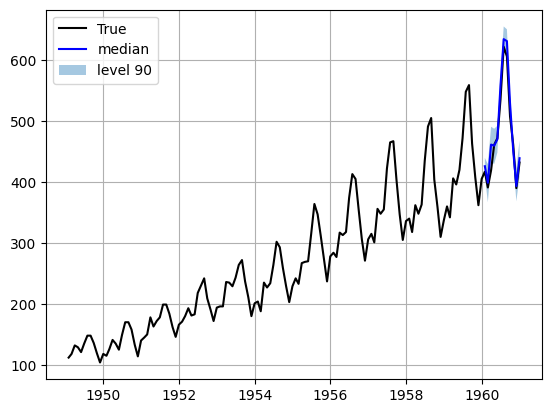

: 

In [ ]:
# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NHITS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['NHITS-lo-90'][-12:].values, 
                 y2=plot_df['NHITS-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()

In [ ]:
model = NHITS(
    h=h,
    input_size=input_size,
    loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
    n_freq_downsample=[2, 1, 1],
    scaler_type='robust',
    max_steps=200,
    early_stop_patience_steps=10,
    inference_windows_batch_size=1,
    val_check_steps=10,
    learning_rate=1e-3
)

# === 6. Entrenamiento ===
fcst = NeuralForecast(models=[model], freq='min')  # 'D' como etiqueta simbólica de frecuencia
fcst.fit(df=train_df_final, val_size=h, verbose=1)

Seed set to 1


NameError: name 'train' is not defined

## Prophet

In [ ]:
train = train_df_final.drop(columns=['unique_id'])

## New test

In [ ]:
test_filtered_df = test_df[['id'] + target_channels]

test_long = test_filtered_df.melt(id_vars=['id'], var_name='unique_id', value_name='y')
test_long.rename(columns={'id': 'ds'}, inplace=True)

test_long['ds'] = pd.to_timedelta(test_long['ds'] - test_long['ds'].min(), unit='m') + pd.Timestamp("2000-01-01")

test_long.head(10)

In [ ]:
# === 3. Predecir con el modelo entrenado ===
forecast_df = fcst.predict(futr_df=test_long)  # usa el forecast hecho antes

# === 4. Unir predicción y test real ===
merged = test_long.merge(forecast_df.reset_index(), on=['ds', 'unique_id'])

# === 5. Marcar anomalías: fuera del intervalo de confianza (lo_90, hi_90)
merged['is_anomaly'] = (
    (merged['y'] < merged['NHITS-lo-90']) | 
    (merged['y'] > merged['NHITS-hi-90'])
).astype(int)

# === 6. Agregar por ID: si al menos un canal es anómalo, marcar como anomalía
submission = merged.groupby('ds')['is_anomaly'].max().reset_index()
submission.rename(columns={'ds': 'id'}, inplace=True)

# === 7. Guardar en CSV
submission.to_csv('submission_NHITS.csv', index=False)

## LSTM Autoencoder

In [4]:
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.regularizers import l2

timesteps = 5  # ventana temporal
input_dim = X_train.shape[1]

# Preprocesar para secuencia
def create_sequences(data, timesteps):
    return np.array([data[i:i+timesteps] for i in range(len(data)-timesteps)])

X_train_seq = create_sequences(X_train, timesteps)
X_test_seq = create_sequences(X_test, timesteps)

# Regularización
l2_reg = l2(0.001)  # Puedes ajustar este valor

inputs = Input(shape=(timesteps, input_dim))

# LSTM codificador con regularización
encoded = LSTM(64, 
               return_sequences=False, 
               dropout=0.2, 
               recurrent_dropout=0.2,
               kernel_regularizer=l2_reg)(inputs)

# Repeat
decoded = RepeatVector(timesteps)(encoded)

# LSTM decodificador con regularización
decoded = LSTM(64, 
               return_sequences=True, 
               dropout=0.2, 
               recurrent_dropout=0.2,
               kernel_regularizer=l2_reg)(decoded)

# Salida con regularización en Dense
outputs = TimeDistributed(Dense(input_dim, kernel_regularizer=l2_reg))(decoded)

# Modelo
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()


I0000 00:00:1746262047.637015    5114 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4047 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:2d:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 6)           │           390 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,590 (201.52 KB)

 Trainable params: 51,590 (201.52 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.fit(X_train_seq, X_train_seq, epochs=2, batch_size=1024, shuffle=True, verbose=1)

2025-05-03 10:47:29.139364: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1582105440 exceeds 10% of free system memory.
2025-05-03 10:47:30.432748: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1582105440 exceeds 10% of free system memory.
2025-05-03 10:47:31.517668: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1582105440 exceeds 10% of free system memory.
2025-05-03 10:47:31.914349: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1582105440 exceeds 10% of free system memory.


Epoch 1/2
12876/12876 ━━━━━━━━━━━━━━━━━━━━ 1282s 99ms/step - loss: 0.1693
Epoch 2/2
12876/12876 ━━━━━━━━━━━━━━━━━━━━ 1310s 102ms/step - loss: 0.1083


In [8]:
X_test_seq_reconstructed = model.predict(X_test_seq, batch_size=1024)
per_channel_error_seq = np.abs(X_test_seq - X_test_seq_reconstructed)
z_scores_seq = (per_channel_error_seq - per_channel_error_seq.mean(axis=0)) / (per_channel_error_seq.std(axis=0) + 1e-8)
aggregated_scores = z_scores_seq.max(axis=2).mean(axis=1)

510/510 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step


## BLSTM Autoencoder

In [5]:
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Input, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

timesteps = 5
input_dim = X_train.shape[1]

# Preprocesar para secuencia
def create_sequences(data, timesteps):
    return np.array([data[i:i+timesteps] for i in range(len(data)-timesteps)])

X_train_seq = create_sequences(X_train, timesteps)
X_test_seq = create_sequences(X_test, timesteps)

# Regularización L2
l2_reg = l2(0.001)

inputs = Input(shape=(timesteps, input_dim))

# Codificador bidireccional
encoded = Bidirectional(LSTM(64, 
                             return_sequences=False,
                             dropout=0.2,
                             recurrent_dropout=0.2,
                             kernel_regularizer=l2_reg))(inputs)

# Repetimos la codificación para cada timestep
decoded = RepeatVector(timesteps)(encoded)

# Decodificador bidireccional
decoded = Bidirectional(LSTM(64,
                             return_sequences=True,
                             dropout=0.2,
                             recurrent_dropout=0.2,
                             kernel_regularizer=l2_reg))(decoded)

# Salida TimeDistributed
outputs = TimeDistributed(Dense(input_dim, kernel_regularizer=l2_reg))(decoded)

# Modelo
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

I0000 00:00:1746340386.743767    4011 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4047 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:2d:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        36,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 5, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 6)           │           774 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,942 (531.02 KB)

 Trainable params: 135,942 (531.02 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.fit(X_train_seq, X_train_seq, epochs=2, batch_size=1024, shuffle=True, verbose=1)

2025-05-04 08:33:08.507060: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1582105440 exceeds 10% of free system memory.
2025-05-04 08:33:09.691133: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1582105440 exceeds 10% of free system memory.
2025-05-04 08:33:10.945088: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1582105440 exceeds 10% of free system memory.
2025-05-04 08:33:11.280637: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1582105440 exceeds 10% of free system memory.


Epoch 1/2
12876/12876 ━━━━━━━━━━━━━━━━━━━━ 2658s 206ms/step - loss: 0.1277
Epoch 2/2
12876/12876 ━━━━━━━━━━━━━━━━━━━━ 2591s 201ms/step - loss: 0.0630


In [7]:
X_test_seq_reconstructed = model.predict(X_test_seq, batch_size=1024)
per_channel_error_seq = np.abs(X_test_seq - X_test_seq_reconstructed)
z_scores_seq = (per_channel_error_seq - per_channel_error_seq.mean(axis=0)) / (per_channel_error_seq.std(axis=0) + 1e-8)
aggregated_scores = z_scores_seq.max(axis=2).mean(axis=1)

510/510 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step


## Conv1D-LSTM + Attention

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, LSTM, RepeatVector, TimeDistributed, Dense,
    Attention, LayerNormalization, Concatenate
)
from tensorflow.keras.optimizers import Adam

# Parámetros
input_dim = X_train.shape[1]
latent_dim = 64

# Encoder
inputs = Input(shape=(timesteps, input_dim))
x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(inputs)
x = LSTM(latent_dim, return_sequences=True)(x)
x = LayerNormalization()(x)

# Atención (clave = valor = x)
attention = Attention()([x, x])
context = Concatenate()([x, attention])
encoded = LSTM(latent_dim, return_sequences=False)(context)

# Decoder
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(latent_dim, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)

# Modelo
model = Model(inputs, decoded)
model.compile(optimizer=Adam(1e-3), loss='mse')
model.summary()

I0000 00:00:1746945127.819050    6474 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4047 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:2d:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 32)     │        608 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 5, 64)     │     24,832 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 64)     │        128 │ lstm[0][0]        │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 5, 64)     │          0 │ layer_normalizat… │
│ (Attention)         │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 128)    │          0 │ layer_normalizat… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     49,408 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 5, 64)     │          0 │ lstm_1[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 5, 64)     │     33,024 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 5, 6)      │        390 │ lstm_2[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 108,390 (423.40 KB)

 Trainable params: 108,390 (423.40 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train_seq, X_train_seq,
    epochs=1,
    batch_size=1024,
    validation_data=(X_val_seq, X_val_seq),
    verbose=1
)

2025-05-11 08:32:09.348287: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1265684160 exceeds 10% of free system memory.
2025-05-11 08:32:10.638145: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1265684160 exceeds 10% of free system memory.
2025-05-11 08:32:11.701723: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1265684160 exceeds 10% of free system memory.
2025-05-11 08:32:11.927460: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1265684160 exceeds 10% of free system memory.
I0000 00:00:1746945135.376963    6668 cuda_dnn.cc:529] Loaded cuDNN version 90300


10301/10301 ━━━━━━━━━━━━━━━━━━━━ 202s 19ms/step - loss: 0.1018 - val_loss: 9.5478e-04


In [8]:
X_val_seq_reconstructed = model.predict(X_val_seq, batch_size=1024)
per_channel_error_val = np.abs(X_val_seq - X_val_seq_reconstructed)
z_scores_val = (per_channel_error_val - per_channel_error_val.mean(axis=0)) / (per_channel_error_val.std(axis=0) + 1e-8)
aggregated_scores_val = z_scores_val.max(axis=2).mean(axis=1)

# 2. Calcular umbral basado en validación (e.g. media + 3 * std)
threshold = aggregated_scores_val.mean() + 3 * aggregated_scores_val.std()
threshold

2576/2576 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step


np.float32(3.1936722)

In [9]:
X_test_seq_reconstructed = model.predict(X_test_seq, batch_size=1024)
per_channel_error_seq = np.abs(X_test_seq - X_test_seq_reconstructed)
z_scores_seq = (per_channel_error_seq - per_channel_error_seq.mean(axis=0)) / (per_channel_error_seq.std(axis=0) + 1e-8)
aggregated_scores = z_scores_seq.max(axis=2).mean(axis=1)

510/510 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


## Conv1D-BLSTM + Attention

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, LSTM, Bidirectional, RepeatVector, TimeDistributed, Dense,
    Attention, LayerNormalization, Concatenate
)
from tensorflow.keras.optimizers import Adam

# Parámetros
input_dim = X_train.shape[1]  # Número de canales
latent_dim = 64

# Encoder
inputs = Input(shape=(timesteps, input_dim))
x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(inputs)
x = Bidirectional(LSTM(latent_dim, return_sequences=True))(x)
x = LayerNormalization()(x)

# Atención (clave = valor = x)
attention = Attention()([x, x])
context = Concatenate()([x, attention])
encoded = Bidirectional(LSTM(latent_dim, return_sequences=False))(context)

# Decoder
decoded = RepeatVector(timesteps)(encoded)
decoded = Bidirectional(LSTM(latent_dim, return_sequences=True))(decoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)

# Modelo
model = Model(inputs, decoded)
model.compile(optimizer=Adam(1e-3), loss='mse')
model.summary()

I0000 00:00:1746891678.408197    4520 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4047 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:2d:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 7, 32)     │        608 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 7, 128)    │     49,664 │ conv1d[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 7, 128)    │        256 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 7, 128)    │          0 │ layer_normalizat… │
│ (Attention)         │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 256)    │          0 │ layer_normalizat… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 7, 128)    │          0 │ bidirectional_1[… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 7, 128)    │     98,816 │ repeat_vector[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 7, 6)      │        774 │ bidirectional_2[… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 314,470 (1.20 MB)

 Trainable params: 314,470 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_seq, X_train_seq,
    epochs=2,
    batch_size=1024,
    validation_data=(X_val_seq, X_val_seq),
    verbose=1
)

2025-05-10 17:41:20.161672: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1771957488 exceeds 10% of free system memory.
2025-05-10 17:41:21.859623: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1771957488 exceeds 10% of free system memory.
2025-05-10 17:41:23.791693: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1771957488 exceeds 10% of free system memory.
2025-05-10 17:41:24.101066: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1771957488 exceeds 10% of free system memory.


Epoch 1/2


I0000 00:00:1746891692.135849    4684 cuda_dnn.cc:529] Loaded cuDNN version 90300


10301/10301 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1391

In [ ]:
X_test_seq_reconstructed = model.predict(X_test_seq, batch_size=1024)
per_channel_error_seq = np.abs(X_test_seq - X_test_seq_reconstructed)
z_scores_seq = (per_channel_error_seq - per_channel_error_seq.mean(axis=0)) / (per_channel_error_seq.std(axis=0) + 1e-8)
aggregated_scores = z_scores_seq.max(axis=2).mean(axis=1)

510/510 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


# Test

In [ ]:
# 5. UMBRAL POR PERCENTIL Y PRUNING
threshold = np.percentile(aggregated_scores, 98) # Adjust this value as needed
binary_scores = (aggregated_scores > threshold).astype(int)

def prune_anomalies(anoms, min_len=10):
    anoms = anoms.copy()
    labels, num = label(anoms)
    for i in range(1, num+1):
        idx = np.where(labels == i)[0]
        if len(idx) < min_len:
            anoms[idx] = 0
    return anoms

is_anomaly = prune_anomalies(binary_scores, min_len=10)

In [9]:
is_anomaly.shape, test_df.shape

((521275,), (521280, 88))

In [10]:
type(X_test_seq)

numpy.ndarray

# Export CSV

In [ ]:
aligned_ids = test_df["id"].iloc[timesteps:].reset_index(drop=True)

submission_df = pd.DataFrame({
    "id": aligned_ids,
    "is_anomaly": is_anomaly
})

submission_df.to_csv("../out/Conv1D-LSTM_Attention_Telemanom_0_new_threshold.csv", index=False)

In [ ]:
# 6. EXPORTACIÓN
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "is_anomaly": is_anomaly
})
submission_df.to_csv("../out/LSTM_AE_Telemanom_0_98.csv", index=False)

In [19]:
df = pd.read_csv("../out/LSTM_AE_Telemanom_0_98.csv")
df["is_anomaly"].value_counts()

is_anomaly
0    516783
1      4492
Name: count, dtype: int64